In [52]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [53]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [54]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [55]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [6]:
newsgroups_train.data[:2]

["Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych",
 '\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.']

In [11]:
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [61]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [62]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense()
vectors.shape

(2034, 26576)

In [63]:
type(vectors)

numpy.matrixlib.defmatrix.matrix

In [17]:
vocab = np.array(vectorizer.get_feature_names())

In [20]:
vocab, vocab.shape #array of all words in the corpus

(array(['00', '000', '0000', ..., 'zware', 'zwarte', 'zyxel'], 
       dtype='<U80'), (26576,))

### SVD

In [21]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 3min 3s, sys: 50.3 s, total: 3min 53s
Wall time: 32.1 s


In [26]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [28]:
reconstructed_vectors = np.matmul(np.matmul(U, np.diag(s)), Vh)

In [29]:
#checking if reconstructed vectors are nearly same as the original vectors
np.allclose(reconstructed_vectors, vectors)

True

In [30]:
# checking if U  and Vh are orthonormal
np.allclose(np.matmul(U.T, U), np.eye(U.shape[0]))

True

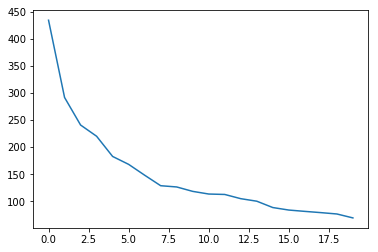

In [43]:
plt.plot(s[:20])

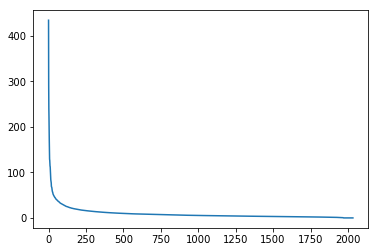

In [42]:
plt.plot(s)

In [49]:
num_top_words = 10

def show_top_words_in_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [50]:
show_top_words_in_topics(Vh[10:20])

['larson theory universe physical den p2 p3 p1 time unified',
 'den p2 p3 p1 radius p23 p13 p12 p4 double',
 'judas hanging reply db mr decenso greek death acts say',
 'atheists atheism religious people religion prophecy matthew messiah course isaiah',
 'space graphics people like sgi research package society good model',
 'telescope word national observatory satellite atheists infrared prefix hst ray',
 'people like nasa don think just time gay want life',
 'ra space atheists religious belief atheism edu larson beliefs fallacy',
 'space posting list sci posts response subject god news universe',
 'astronaut program pilot nasa candidates mission military degree shuttle applicants']

### Non-negative Matrix Factorization

In [51]:
from sklearn.decomposition import NMF

In [65]:
vectors[0]

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [67]:
clf = NMF(n_components=5, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [69]:
W1.shape, H1.shape

((2034, 5), (5, 26576))

In [71]:
show_top_words_in_topics(H1)

['jpeg image gif file color images format quality version files',
 'edu graphics pub mail 128 ray ftp send 3d com',
 'space launch satellite nasa commercial satellites year market data earth',
 'jesus god people matthew atheists does atheism said just believe',
 'image data available software processing ftp edu analysis images display']

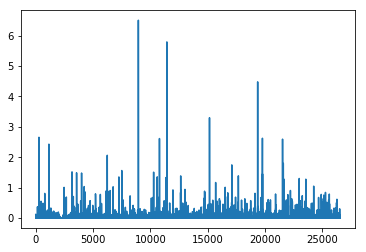

In [74]:
plt.plot(H1[1])

6.5075815550104021

### NMF from scratch using Stochastic Gradient Descent

In [110]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [158]:
lr=0.1
mu = 1e-6
m,n = vectors.shape

In [159]:
W = np.abs(np.random.normal(scale=0.01, size=(m,5)))
H = np.abs(np.random.normal(scale=0.01, size=(5,n)))

In [160]:
def grads(M, W, H):
    temp = np.dot(W, H) - M
    grad_W = np.dot(temp, H.T)
    add_W = np.where(grad_W > mu, 0, grad_W - np.amin(grad_W))
    grad_H = np.dot(temp.T, W)
    add_H = np.where(grad_H > mu, 0, abs(grad_H - np.amin(grad_W)))
    
    g_W = grad_W + add_W*0.01
    g_H = grad_H + add_H*0.01
    
    return g_W, g_H.T

In [161]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [162]:
def report(M,W,H): 
    print(np.linalg.norm(M-np.dot(W,H)), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [163]:
report(vectors_tfidf, W, H)

44.4249388394 5.24865902722e-06 9.82880388954e-08 0 0


In [164]:
upd(vectors_tfidf,W,H,lr)

In [ ]:
report(vectors_tfidf, W, H)

44.3783598946 -0.00974731182723 -0.000818025372158 1758 2809


In [ ]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 5 == 0: report(vectors_tfidf,W,H)

44.3556486932 -0.00967638347793 -0.00118432441665 1127 3614
44.1921501589 -0.0086193898171 -0.00803185729678 531 20431
44.1135655404 -0.0200809735476 -0.0151320272958 882 42781
44.0355951515 -0.0698044413688 -0.0940949877717 1790 51448
